## This notebook does the follwoing:
- loads an SED dataset (lazily)
- User defines diffraction calibration, min angle / max angle / virtual detector width 
- We generate a series of virtual ADF images (summing in diff plane over ranges defined by above params)
- Saves the images in a sub-dir VDF_images to the path where the data is located

In [1]:
%matplotlib notebook
import hyperspy.api as hs
import pyxem as pxm
import numpy as np
import os

In [2]:
data_path = '/dls/e02/data/2022/cm31101-4/processing/Merlin/au_xgrating/20220823_103205/20220823_103205_data.hdf5'
d = hs.load(data_path, lazy=True)
print(d)

<LazyElectronDiffraction2D, title: , dimensions: (255, 255|515, 515)>


In [3]:
min_ang = 50 # in pix
max_ang = 200 # in pix
detector_width = 10 # in pix
diff_cal = 0.00942 # A^-1 to pix

In [4]:
d

<LazyElectronDiffraction2D, title: , dimensions: (255, 255|515, 515)>

In [5]:
d.set_diffraction_calibration(diff_cal)

In [6]:
d_mean = d.mean()

In [7]:
d_mean.compute()

[########################################] | 100% Completed |  2min  4.3s


In [8]:
shift =  d_mean.center_direct_beam(method='blur', sigma=1, return_shifts=True)

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


In [9]:
shift.data

array([ 18.5, -29.5])

In [10]:
d.center_direct_beam(shifts=shift)

In [11]:
step_num = int((max_ang - min_ang) / detector_width)
print(step_num)

15


In [12]:
base_dir = os.path.dirname(data_path)
save_dir = os.path.join(base_dir, 'VDF_images')
save_dir
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

<IPython.core.display.Javascript object>


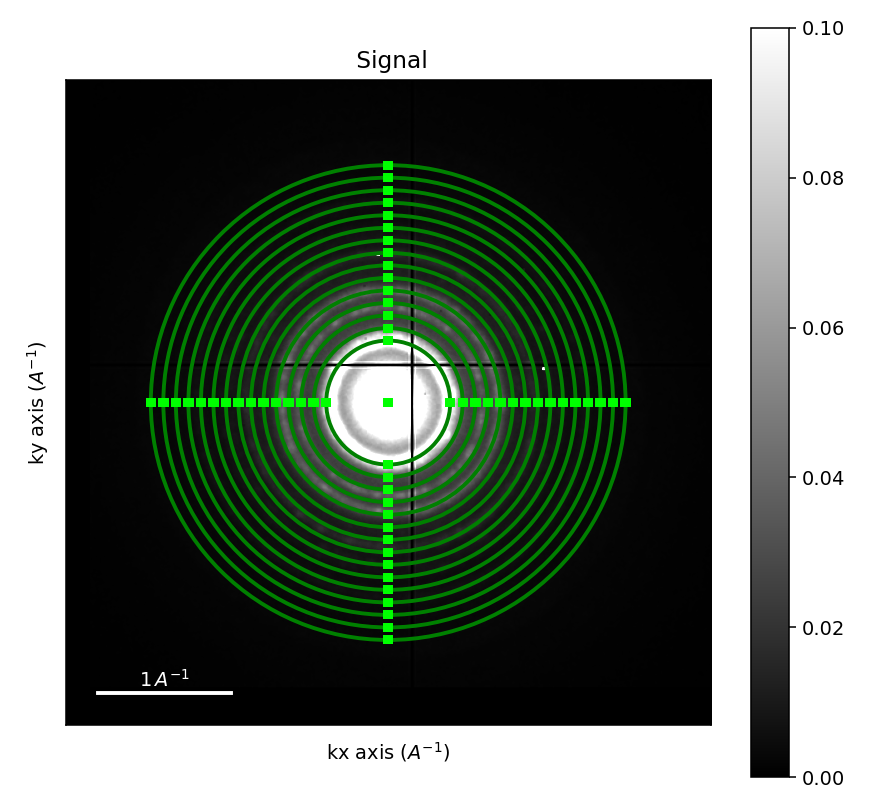

[########################################] | 100% Completed |  3min 32.6s


[########################################] | 100% Completed |  3min 38.3s


[########################################] | 100% Completed |  3min 40.9s


[########################################] | 100% Completed |  3min 44.3s


[########################################] | 100% Completed |  3min 35.9s


[########################################] | 100% Completed |  3min 37.3s


[########################################] | 100% Completed |  3min 39.3s


[########################################] | 100% Completed |  3min 41.8s


[########################################] | 100% Completed |  3min 29.8s


[########################################] | 100% Completed |  3min 50.4s


[########################################] | 100% Completed |  4min  7.7s


[########################################] | 100% Completed |  3min 48.1s


[########################################] | 100% Completed |  3min 44.3s


[########################################] | 100% Completed |  4min  4.1s


[########################################] | 100% Completed |  3min 43.3s


In [31]:
import gc
d_mean.plot(vmax=0.1)
d_T = d.T
for i in range(step_num):
    adf_det = hs.roi.CircleROI(cx=0.0, cy=0.0, 
                               r=(min_ang + i * detector_width) * diff_cal, 
                               r_inner=min_ang * (i + 1) * diff_cal)
    adf_sig = adf_det.interactive(d_T, navigation_signal=d_mean)
    adf_sig = adf_sig.data.astype('uint16')
    adf_sig[np.isnan(adf_sig)] = 0
    adf_sig = hs.signals.Signal2D(adf_sig).as_lazy()
    
    adf_sig.compute()
    adf_im = adf_sig.sum()
    adf_im = 255 * adf_im.data / np.max(adf_im.data)
    adf_im = hs.signals.Signal2D(adf_im)
    adf_im.save(f'{save_dir}/vdf_{i}.jpg')
    
    del(adf_sig)
    del(adf_im)
    gc.collect()